# Introduction

In this notebook I explained how to tackle a machine learning from the beginning to the end, at the example of predicting housing prices. It covers a lot of tool & techniques, that are common in the machine learning landscape.

After reading it, you will know everything you need, to build your own regression system. I got everything I cover in this notebook from the book "Hands-On Machine Learning with Scikit_learn & Tensorflow" from Aurelien Geron. I used the California Housing Dataset from the statlib repository.

If you just want to have a quick look at what I did and what I've learned throughout writing this notebook, you can just read the [summary](#Summary) at the very end.  



## Table of Contents:

- [Import Libraries](#importo) 
    
- [California housing Dataset](#data)

- [Big Picture](#bigp)

- [Train/Test Split](#split)

- [Extensive Data Exploration](#explo)
    -  [Searching for Correlations](#corre)
    
    


- [Data Preparation](#prep)
    - [How to process Categorical Attributes and Text](#categ)
    - [Custom transfer](#custom) 
    - [Feature Scaling](#scale)
    - [Pipelines for tranformation](#pipe)
    
    
        
- [Train Models](#train)

- [Fine Tuning](#tune)

- [Evaluation](#evaluation)

- [Summary](#summary)

<a id='importo'></a>

# Import Libraries

<a id='import'></a>

In [1]:
# Common imports
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# random seed to make output stable across runs
np.random.seed(42)

# data visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

<a id='data'></a>

# **California housing Dataset**

The dataset we will use is the "California Housing Prices" dataset from the statlib repository, which is based on data from the 1990 census. This dataset offers great opportunities for learning. The prediciton task for this dataset wil be to predict housing prices based on several features.

### Get the data:

In [2]:
import os
import tarfile
from six.moves import urllib

root = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
path = os.path.join("datasets", "housing")
source = root + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=source, path=path):
    if not os.path.isdir(path):
        os.makedirs(path)
    tgz_path = os.path.join(path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_data(housing_path=path):
    csv = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv)

<a id='bigpop'></a>

# Big Picture

You are asked to build a machine learning model that predicts the median house value for a given "district". This data has metrics like population, median income, median housing price for each block group in califorania. Block groups are smallest geographical unit for which the US Census Bureu publishes data. I will just call them "districts" for now.

Frame the problem:

Is it supervised, unsupervised or reinforcement learning ? Is it a classification task, a regression task or something different ? 
Our problem is clearly a supervised learning task, because you have labeled input data. It is also clearly a regression task since you have to predict a numeric value. 

In [5]:
housing = load_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Above you can see the top 5 rows of the dataset with the "head()" method. 

Each row  represents one district. The dataset has 10 attributes: longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value and ocean_proximity.

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Now you can see a brief description of the data using the "info()" method above.

Notice that there are 20,640 instances (entries) in the whole dataset. Also notice that the total_bedrooms attribute has only 20,433 non-null values which means that 207 districts don't have this feature. You can also see that ocean_proximity is not numerical and probably a categorical attribute. You can find out how many districts belong to each attribute by using the "value_counts()" method, which I used below.

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Now I will use the "describe()" method to show a summary of the numerical attributes:

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


I hope the count, mean, min and max rows are self explanatory for you. Be aware of the fact, that all null values are ignored here (count of total_bedrooms is 20,433 not 20,640). The std row shows you the standard deviation, which quantifies the amount of variation between the values. The 25%, 50%, 75% are the percentiles. For an example 75% of the districts have housing_median_age of lower than 37 while 50% are lower than 29 and 25% are lower than 18. These are often called the 25th percentile (or 1st quartile), the median and the 75th percentile (or 3rd quartile).

Another good way to explore a given dataset is to plot a histogrom of each numerical attribute. A histogram shows you the number of instances (vertical axes) and the number of the given value range (horizontal axes)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114c0dc50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110e9f278>]], dtype=object)

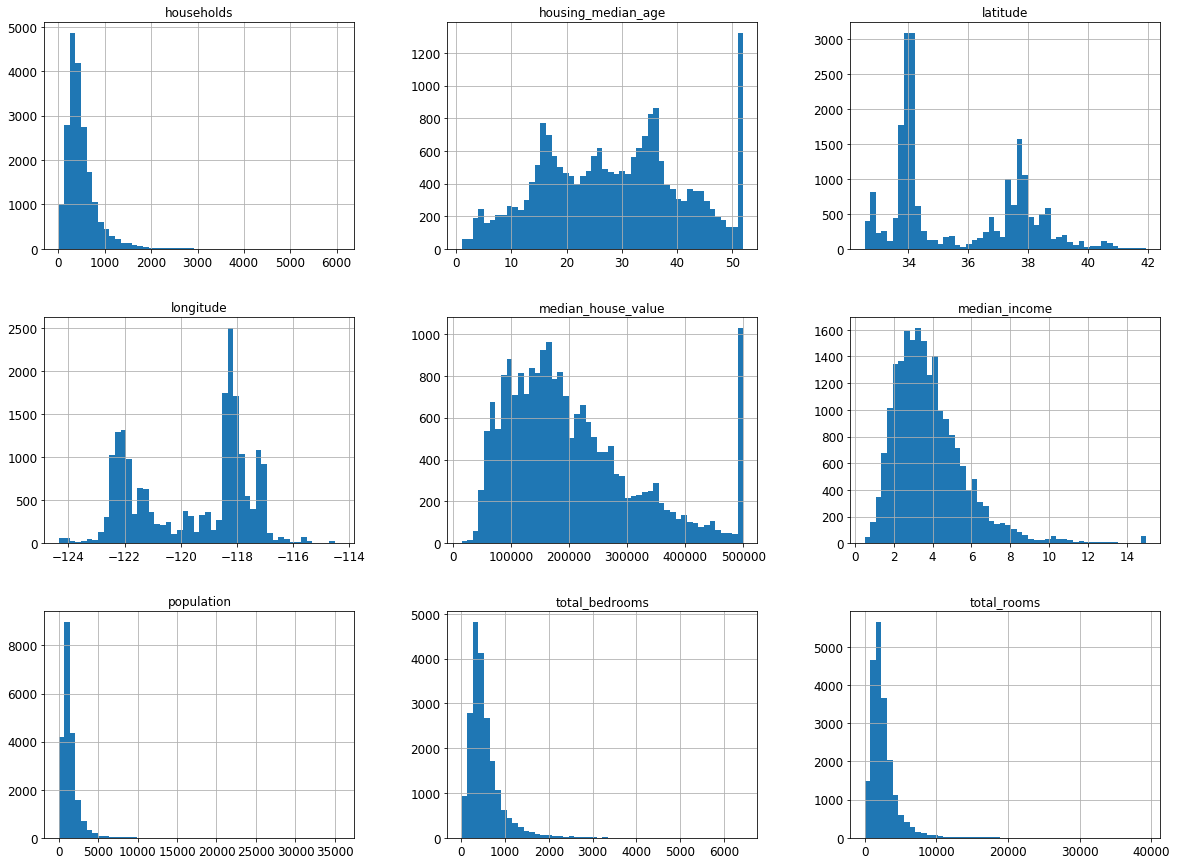

In [9]:
%matplotlib inline
housing.hist(bins=50, figsize=(20, 15))

What you should notice about the histograms above:

* The attributes have varying scales, which we will discuss later on in this post.
* Many of the histograms are "tail heavy" which means that they extend further to the right of the median than to the left which makes it harder for an algortihm to detect patterns. We will transform the later on.
* The median_income attribute is not in US Dollar because the data has been scaled and capped at 15.0001 and at 0.4999. This is called a "preprocessed attribute" and is common within machine learning, but you should understand how the data was preprocessed.
* The housing_median_age and the median_house_value attributes are also capped. That the median_house_value is capped could be a serious problem, because this is your label (what you want to predict) and your model could learn that the price never goes beyond that limit. In this case we only have the option to remove the capped one or to collect the right labels for them.



<a id='split'></a>

# Train/Test Split

It is important that we now set a part of the data aside. Your brain is an amazing pattern detection system and therefore extremly prune to overfitting. If you would also look at the test set during the visual explaration, which we will do now, you may find some patterns unconsciously within the data, which let you select a particular algorithm that leads to an overfitted model. Because of that you could launch a system that performs not as well on new data than expected.


We use the straight forward "train_test_split()" method from sklearn to split our data into train and test subsets. For further information you can look at the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [10]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "Train Instances +", len(test_set), "Test Instances")

16512 Train Instances + 4128 Test Instances


Now we splitted our data purely random, which is fine if you have a large dataset, but if it is not, you could have a sampling bias. When a company decides to call 10,000 people because of a survey, they want to make sure that these people represent the whole population. For an example the US population consists out of 49% male and 51% female, so a well conducted survey would try to maintain this ratio, which is called **stratified sampling**.  The population is divided into homogeneous subgroups, called **strata** and the right number of instances is sampled from each **stratum** to makes sure that the data really represents the population. 

Imagine that you talked with real estate experts and they tell you, that the median_icome attribute is very important, when you want to predict housing prices. If that's the case, you want a test set that is really representative of the income categories of the dataset. Because median_income is continous, you need to convert it into a categorical attribute. If you look again at the holograms we analyzed detailed above, you may notice that most median income values are clustered around 20,000 - 50,000 but some go far beyond 60,000. It is very important that you don't have too many strata and that each stratum should have a sufficient number of instances. If this is not the case, the estimate of the stratums importance may be biased and your model could think that a stratum is less important. 

The code below transforms the median_income attribute into a categorical one by dividing the median income by 1.5 to limit the number of income categories and rounds it up using "np.ceil()" to have discrete categories. It merges all the categories that are greater than 5 into category 5. The categories are represented in the histogram below the code.

In [11]:
housing["income_categories"] = np.ceil(housing["median_income"] / 1.5)
housing["income_categories"].where(housing["income_categories"] < 5, 5.0, inplace=True)

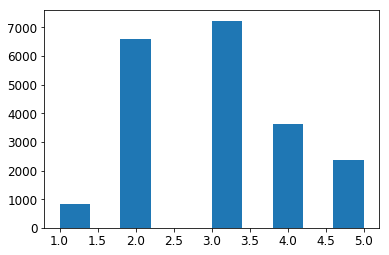

In [12]:
plt.hist(housing["income_categories"])
fig = plt.gcf()


Lats but not least you need to do stratified sampling based on the income categories. You can use sklearn's "StratifiedShuffleSplit" class:

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_categories"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

The code below just generates the table and compares the different sampling types.

In [14]:
def income_categories_proportions(data):
    return data["income_categories"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_categories_proportions(housing),
    "Stratified": income_categories_proportions(strat_test_set),
    "Random": income_categories_proportions(test_set),
}).sort_index()


In [15]:
compare_props

,Overall,Random,Stratified
1.0,0.039826,0.040213,0.039729
2.0,0.318847,0.324370,0.318798
3.0,0.350581,0.358527,0.350533
4.0,0.176308,0.167393,0.176357
5.0,0.114438,0.109496,0.114583


Now we want to remove the income_categoreis attribute because we don't need it anymore.

In [16]:
housing  = housing.drop(['income_categories'], axis=1)

<a id='explo'></a>

# Extensive Data Exploration

Now it is time for exploring the data. First of all, we want to visualize the geographical data with latitude and longitude. A good way to do this is to create a scatterplot of all the districts. It is important that you set alpha equal to 0.1, because then the scatterplot has a high density and therefore it is much easier to visualize.

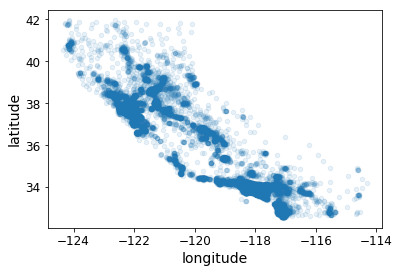

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

If you are fimiliar with California you can clearly see, the high density in the Bay Area, Los Angelos, San Diego and in the Central Valley around Sacramento and Fresno. Our brains are very good at finding patterns on pictures but you often need to play around with the parameters to make the important patterns really stand out.

Now we will look at the housing prices at the scatterplot below. The color represents the price and the radius of each circle represents the districts population.

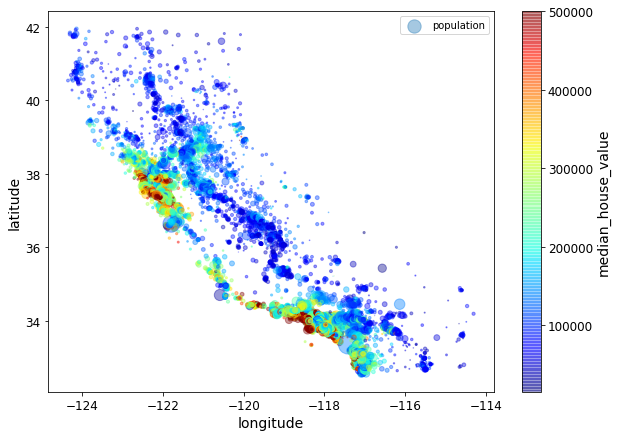

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

On the scatterplot we can see, that the housing prices are related to the location (close to the ocean) and to the population density, but we know that the housing prices of costoal districts are not that high in Northern California, so we can't make that rule as simple as that.  

<a id='corre'></a>


### Searching for Correlations:

The housing dataset isn't that large and therefore we can easily compute the correlations between every attribute using the "corr()" method. We will start by looking how much each attribute is correlated to the median house value.

In [19]:
correlations = housing.corr()
correlations["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

The coefficient of the correlation ranges from 1 to -1. The closer it is to 1 the more correlated it is and vice versa.  Correlations that are close to 0, means that there is no correlation, neither negative or positive. You can see that the median_income is correlated the most with the median house value. Because of that, we will generate a more detailed scatterplot below:

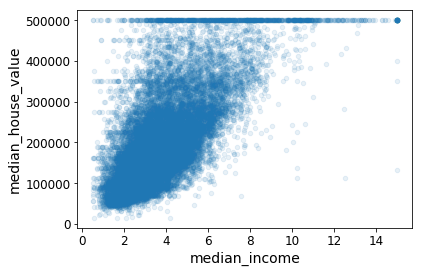

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

The scatterplot reveals, that the correlation is indeed very strong because we can clearly see an upward trend and the points are not to dispersed. We can also clearly see the price-cap, we talked about earlier, at 500 000 as a horizontal line. Other less obvious lines are around 450 000, 350 000 and 280 000. We may have to remove the corresponding districts to prevent the model from learning to reproduce these data faults. 

I hope that the previous explanation and visulizations made you more comfortable with the concepts of exploring data to gain insights. We identified a few very important faults in the data that we need to clean up before we can put the data into the machine learning model, that we will build later on. We also found some interesting correlations between the different attributes and we recognized the tail-heavy distribution, that we will also clean up later on. Of course a lot of things are different at every project you will work on, but the general guidelines will be the same and therefore you now already have a good understanding of some of those guidelines. 

Before we now actually prepare the data to fed it into the model, we should think about combinating a few attributes. For example, the number of rooms within a district is of course not very helpful, if you don't know how many households are within that district. You want the number of roms per household. The number of bedrooms isn't that helpful for the same reason, but it would make sense to compare it with the total number of rooms within a household. Also the population per household would be an interesting attribute. I will create these new attributes in the code below and then we will look at the correlation matrix again.

In [21]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

Now we see, that the bedrooms_per_room attribute is more correlated with the median house value than the total number of rooms or bedrooms. Houses with a lower bedroom/room ratio tend to be more expensive. The rooms_per_household attribute is also better than the total number of rooms in a district. Obviously the larger the house, the higher the price.

The part of exploring the data does not have to be fully thorough and accurated. The reason why we do it, is to gain a few important insights, that we can use when we build our model. Building proper Machine Learning models is a very iterative process, which means you gain some insights, build a model and then you try to gain more insights and update the model that it works better and so on. You will continue to do this, till you reached a satisfying accuracy and will probably try out several algorithms and paratemer adjustments on your way.

<a id='prep'></a>

# Data Preparation

Now it is time to prepare the data so that our model can process it. We will write functions that do this instead of doing it manually. The reason for this is, that you can reuse these on a new dataset and at new projects you will work on. But first, let's revert to a clean training set by copying start_train_set and let's separate the predictors and the labels since we don't necessarily want to apply the same tranformations to the predictors and the target values.

In [23]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

We noticed earlier that the total_bedrooms attribute has some missing values. Most Machine Learning algorithms can't work with datasets that have missing values. 

There are 3 ways to solve this problem:

1.) You could remove the whole attribute

2.) You could get rid of the districts that contain missing values.

3.) You could replace them with zeros, the median or the mean

We chose option 3 and will compute the median on the training set. Sklearn provides you with "Imputer" to do this. You first need to specify an Imputer instance, that specifies that you want to replace each attributes missing values with the median of that attribute. Because the median can only be computed on numerical attributes, we need to make a copy of the data without the ocean_proximity attribute that contains text and no numbers.

In [24]:
median = housing["total_bedrooms"].median()

from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

housing_num = housing.drop('ocean_proximity', axis=1)

Now we can fit the Imputer instance to the training data using the "fit()" method.

In [25]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

The imputer has simply computed the median of each attribute and stored the result in the statistics variable. We apllied the imputer to all numerical attributes, because it's safer if your system will go live sometimes.

Now we can use the trained imputer to replace the missing values by the learned medians. This results in a plain numpy array but we will transform it back into a pandas dataframe. We will do these 2 steps in the code below.

In [26]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = list(housing.index.values))
housing_tr  = housing_tr.drop(['income_categories'], axis=1)

In [27]:

sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


<a id='categ'></a>

### How to process Categorical Attributes and Text

Like I allready mentioned most of the machine learning algorithms can just work with numerical data. The ocean_proximity attribute is still a categorical feature and we will convert it now. We can use Pandas' factorize() method to convert this string categorical feature to an integer categorical feature.


In [28]:
housing_cat = housing['ocean_proximity']
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [29]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

One issues with this solution is that our algorithm will assume that two nearby values are more similar than two distant values, which is obviously not the case. For axample category 0 and 4 are more similar than categories 0 and 1. A common solution for this problem is to create one binary attribute per category: one attribute equal to 1 when the ctaegory is "<1H OCEAN" and 0 otherwise, another attribute equal to 1 when the category is "INLAND" and 0 otherwise, and so on. This is called "one-hot-encoding", because only one attribute will be equal to 1 (hot) and the others will be 0 (cold). 

We will do exactly this in the code cell below. We use the OneHotEncoder encoder, that sklearn provides,  to convert numeric categorical values into one-hot vectors. Note that "fit_transform()" expects a 2D array but "housing_cat" is a 1D array. Therefore we need to reshape it.

In [30]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The output is a so called **Scipy sparse matrix** and not a numpy array.  A sparse matrix only stores the location of the non zero elements and doesn't stores a matrix full of zeros except for one per row. This saves a lot of memory and is very useful when you have categorical attributes with thousands of categories. For simplicity reasons we want it to be a usual numpy array and therefore we convert it in the code cell below, using the "toarray()" method.

In [31]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

Note that there is a way that combines the two steps in one shot ( from categories to integer categories and then from integer categories to one-hot vectors). You can use Scikit-Learn's upcoming CategoricalEncoder class, which will soon be added to Scikit-Learn, and in the meantime you can use the code below (copied from Pull Request #9151 of Aurelien Geron).

In [32]:
# copied from PR #9151.
# Just run this cell or copy it to your code. You don't need to understand it right now.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

The CategoricalEncoder expects a 2D array, containing one or more categorical input features. We need to reshape housing_cat to a 2D array:

In [33]:
cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

We use toarray() again to get a dense array:

In [34]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [35]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

<a id='custom'></a>

### Custom transfer

Sklearn provides us with many different useful built in functions that help us to preprocess data and a lot of other stuff. But you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You want that the functions you write are working flawless togehter with sklearn functionalities like pipelines for example. Since Sklearn relies on [duck typing](http://davidasboth.com/2016/11/14/duck-typing/), all you need to do is to create a class and implement the three following mehtods: fit(), transform() and fit_transform(). You get the last one simply by adding **TransformerMixin** as a base class. And if you add **BaseEstimator** as a base class, and avoid "*args" and "*kargs" in your code, you will get two extra methods (get_params() and set_params()), which will we useful to automatically tune your hyperparameters. To illustrate this, I wrote a small transformer class below that adds the combined attributes:

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [37]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_categories,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,5,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,2,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3,4.50581,3.04785


Here the transformer has one hyperparameter, which is set to true by default and allows you to easily find out whether adding this attribute helps the machine learning model or not. You can add any hyperparameter to gate any data preparation step you are not sure about. The more you automate the data prepration steps, the more combinations you can try out, which therefore makes it much more likely that you find a great one and save a lot of time.

<a id='scale'></a>

### Feature Scaling

Feature scaling is one of the most important transformations you need to apply, since nearly all machine learning algorithms perform bad when the input numerical attributes have widely varying scales, which is the case at our current dataset. For example, the median incomes range from o to 15, but the total number of rooms from 6 to 39,320. Note that scaling the target values is not required.

There are two common ways:

**1.) min-max scaling**

**2.) standardization**

With min-max sclaing the values are shifted and rescaled that they range from 0 to 1. This can be done by subtracting the **min value** and dividing by the **max** minus the **min**. Sklearn's  transformer called **MinMaxScaler**, which has a feature_range hyperparameter, that let's you change the range to whatever you want to (instead of 0 to 1), can do this for you. 

Standardization subtracts the mean value and divides it by the variance. It does not bound the values into a specific range, which can be good or bad. Neural Networks for example often need input values that range from 0 to1. The good thing is, that standardization is less effected by outliers. If for example, you suppose a district has a median income of 100 (by mistake), min-max scaling would would map the values that range from 0 to 15 down to 0 to 0.15, whereas standardization would give you a much more accurate outcome. With sklearn you can do standardization with the **StandardScaler** tramsformer. And always just do transformations with the training set only, to prevent overfitting. 

<a id='pipe'></a>

### Pipelines for tranformation

There are a lot of data tranformation steps that also need to be done in the right order. To help you with that, sklearn provides the **Pipeline** class. In the code below, you can see a small pipeline of attributes:

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [39]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

The Pipeline constructor takes a list of name/estimator pairs, which define a sequence of steps. Note that all instead of the last estimator must be transformers, which means that they must have a fit_transform() method.  Also note that if you call the pipelines fit() method, it calls fit_transform() on all transformers. In our example, the last estimator is a StandardScaler (for standardization), so the pipeline has a transform() method that applies all the transform to the data in sequence. 

Now it would be nice if we could feed a Pandas DataFrame directly into our pipeline, instead of having to first manually extract the numerical columns into a NumPy array. Unfortunately sklearn provides nothing that does this for us, so we have to write it by ourself:

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

This will tranform our data by selecting the desired attributes, dropping the others and converting the resulting dataframe into a NumPy array. With this in mind you can easily write a pipeline that takes a Pandas dataframe and handle only the numerical values. Just start the pipeline with a **DataFrameSelector** to pick only the numerical attributes. And you can just as easily write another one for the categorical attributes, by simply selecting categorical attributes using a **DataFrameSelector** and then applying a **LabelBinarizer**.

In [41]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

But there is also a way to join these two pipelines into a single pipeline, using sklearns **FeatureUnion**. You can give it a list of transformer-pipelines. A complete pipeline that handles numerical and categorical attributes looks like this:

In [42]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

The code below runs the whole pipeline:

In [43]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

<a id='train'></a>

# Train Models

We looked at the big picture of your problem and framed it, we explored and visualized the data and preprocessed it. Now it is time to select and train a Machine Learning model. The hard part were the previous steps. What we do now, is going to be much simpler and easier.

First, let's test whether a Linear Regression model gives us a satisfying result:

In [44]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's try it out on the training set:

In [45]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 203682.37379543  326371.39370781  204218.64588245   58685.4770482
  194213.06443039]


In [46]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Let's use [RMSE (Root Mean Squared Error)](http://www.statisticshowto.com/rmse/) to judge the quality of our predictions:

In [47]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.642954599374

This is clearly not a great score. Since most districts median_housing_values range between 120,000 and 265,000 dollar, a prediction erro of $68,376 is not very satisfying and also an example of a model underfitting the data. This either means that the features do not provide  enough information to make proper predictions, or that the model is just not powerful enough.


The main ways to fix underfitting are:

1.) feed the model with better features

2.) select a more powerful model

3.) reduce the constraints on the model


First let's try out a more powerful model since we just only tested one.

Let's use a DecisionTreeRegressor, which can find complex nonlinear relationships in the data:

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Let's try it out on the training set:

In [49]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

This gives you no error at all, which means that we strongly overfitted our data. How can we be sure ? As we allready discussed earlier, you don't want to use the test set until you are confident about your model. But how can we test how our model performs if we can't use the test data ? One way to do this is using **K-Fold Cross-Validation**, which uses part of the training set for training and a part for validation. The following code randomly splits the training set into 10 subset called **folds**. Then it trains and evaluates 10 times, using every fold once for either training or validation:

In [50]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Let's look at the result:

In [51]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 70307.54079165  67270.94561829  71361.89886493  68889.91784739
  70992.94150631  74140.66907294  70607.72083897  70576.13836762
  76433.16342183  70270.96266671]
Mean: 71085.1898997
Standard deviation: 2431.96102969


Now we have a real estimate of how the decision tree performs. In fact, it does even perform worse than our previous linear regression model.
Note that cross validation not only gives you an estimate of your models performance, but also of how precise this estimate is (standard deviation). Here we have a prediction error of 71,085 dollar. The standard deviation is 2,431 Dollar, which means that our prediction error could be $2,431 more or less.

Now let's compute the scores for our linear regression model again, but using K-Fold Cross-Validation:

In [52]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66877.52325028  66608.120256    70575.91118868  74179.94799352
  67683.32205678  71103.16843468  64782.65896552  67711.29940352
  71080.40484136  67687.6384546 ]
Mean: 68828.9994845
Standard deviation: 2662.76157061


Now we defenitely know that our decision tree model is overfitting and performs worse than our linear regression model. Now let's try one last model, the RandomForestRegressor. Random Forest works by training many Decision Trees on random subsets of the features and then it averages their predictions. Building a model on top of other models is called **Essemble Learning** and often pushes Machine Learning algortihms further.

In [53]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22112.540875989125

In [55]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 51513.5500248   48821.99364978  53451.63889205  54910.55855153
  50405.68166817  56772.90691171  51909.21824137  50516.14893695
  55699.80788403  53107.7805515 ]
Mean: 52710.9285312
Standard deviation: 2414.72717912


This is a lot better. Note that the score on the training set is still much lower, than on the validation set, which indicates that the model is overfitting the training set and that we should optimize the model to solve this problem. However, you shouldn't fine tune a model too much before you haven't tried out various other machine learning models from different categories of algorithms, without spending to much time tweaking it. You could use different Support Vector Machines with different Kernels, maybe a neural network and so on. The goal is that you have a rough estimate about, what algorithms performs the best and then you should spent time fine tuning them for a better accuracy. Note that you should save every model you tested using pythons [pickle](https://wiki.python.org/moin/UsingPickle) module or sklearn [joblib](http://scikit-learn.org/stable/modules/model_persistence.html).

<a id='tune'></a>

# Fine Tuning

Now let's assume you played around with different algorithms and have a rough estimate over the best performing ones. We will now look at Grid Search as an example to fine tune your model.


### Grid Search
Instead of trying out different hyperparametrs manually until you find some great combinations, you can let Grid Search do that for you. All you need to do is tell it which hyperparameters you want to experiment with and what values. The code below searches for the best combination of hyperparameter values for the RandomForestRegressor: 

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [57]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

This tells us that the best solution would be by setting the max_features to 8 and the n_estimators to 30.

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64265.8521009 {'max_features': 2, 'n_estimators': 3}
55882.9848402 {'max_features': 2, 'n_estimators': 10}
53472.5297705 {'max_features': 2, 'n_estimators': 30}
61320.6172102 {'max_features': 4, 'n_estimators': 3}
53834.6661703 {'max_features': 4, 'n_estimators': 10}
51273.2598733 {'max_features': 4, 'n_estimators': 30}
59851.1600773 {'max_features': 6, 'n_estimators': 3}
53108.4926792 {'max_features': 6, 'n_estimators': 10}
50804.4906775 {'max_features': 6, 'n_estimators': 30}
59225.2197785 {'max_features': 8, 'n_estimators': 3}
52883.782581 {'max_features': 8, 'n_estimators': 10}
50942.1591379 {'max_features': 8, 'n_estimators': 30}
62801.357247 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54452.7056215 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61122.9494918 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53014.3329645 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
60252.6537668 {'bootstrap': False, 'max_features': 4, 'n_estimat

The RMSE score for this combinationis 50,804. Now you have succesfully fine tuned your model ! Alternatives to Grid Search would be [Randomized Search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) (good for exploring many hyperparamter combinations) and [Ensemble Methods](https://www.toptal.com/machine-learning/ensemble-methods-machine-learning). 

<a id='evaluation'></a>

# Evaluation

Now we can evaluate the final model on the test set. You just have to get the labels from your test set, run your full_pipeline to transform the data and eveluate the model:

In [59]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [60]:
final_rmse

49036.586427241818

We now have a final prediciton error of $49,036 and learned a lot of things on the way. Note that usually the performance on the test set is slightly worse, because your system is fine tuned to perform well on the training set. 

Hopefully all of this gave you a good idea of what a machine learning project looks like and a blueprint for you to build great systems in the future. As I already mentioned, most of the work has to be done before you select and train an algorithm. Note that it is propably better to know four or five machine learning algorithms very well rather than spending all your time exploring advanced algorithms and not enough time on the overall process.

<a id='summary'></a>

# Summary

Now we have a pretty good understanding of how supervised regression works and learned a massive amout of things on the way.

We learned how to frame a problem, plot histograms & draw conclusions from it, split data into training & testing subsets and what tailheavyness is & how to solve it. 

We now know why stratified sampling can be very important and we used it on the income_categories feature, after we created it. We also plotted scatterplots, computed a correlation coefficient table, discussed scaled & capped features and even wrote functions for feature engineering. 

In terms of data preparation, we talked about missing values and filled some. We processed categorical attributes and text, using One hot encoding and reshaped arrays along the way. We did some feature scaling and learned that most machine learning algorithms perform bad, when the input numerical attributes have widely varying scales. 

Furthermore we used the sklearn pipeline class, joined two pipelines into a single one, used RMSE to evaluate our models and learned a lot about over- and underfitting. 

On top of that we used K-fold cross validation and tuned our hyperparameters with grid search. 

Along the project we used a Linear Regression model, a DecisionTreeRegressor and a RandomForestRegressor.